**done remotely on greenplanet**

In [1]:
import numpy
import gdal
import osr
import glob
import xarray
import datetime
import re
import cartopy
import cmocean
import matplotlib.pyplot as mp

import dask

open all files as a separate gdal dataset

* store ALL FILES in a list called ```file_list_datetime_all``` (for MOD11A2 size~27,000(
* store all yearday strings in a list called ```file_list_yearday_strings_all```

In [2]:
file_list_all = numpy.array(sorted(glob.glob('/beegfs/DATA/pritchard/blangenb/MODIS_ARCHIVE/MOD11A2/MOD11A2*.hdf')))
file_list_yearday_strings_all = numpy.array([f.split('/')[-1].split('.')[1][1:] for f in file_list_all])
file_list_datetime_all = numpy.array([datetime.datetime.strptime(yd, '%Y%j') for yd in file_list_yearday_strings_all])
yearday_strings_unique_all = numpy.unique(file_list_yearday_strings_all)

specify which yearday to start and end on, and subset only those

**pseudocode**

```
for each year in range(2000, 2018):
    Open up everything, gather all data, save as npy file
    save corresponding times as npy file
```

In [3]:
year_start = 2000
year_end = 2018

In [4]:
datetime.datetime(2001,6,10).timetuple().tm_yday

161

Note 2001-06-26 is missing some tiles, so I've changed the code to 

## for daytime LST

In [45]:
variable = 'LST_day'
instrument = 'MOD11A2'

missing_indices = []

for year in [2002]:#range(2011,2018):
    
    print(year)
    
#     yearday_start = str(year)+'001'
#     yearday_end = str(year+1)+'001'

    yearday_start = str(year)+'160'
    yearday_end = str(year)+'186'
    
    yearday_start_dt = datetime.datetime.strptime(yearday_start, '%Y%j')
    yearday_end_dt = datetime.datetime.strptime(yearday_end, '%Y%j')
    yearday_indices = [(i<yearday_end_dt)&(i>=yearday_start_dt) for i in file_list_datetime_all]

    file_list = file_list_all[yearday_indices] # list of full year files
    file_list_datetime = file_list_datetime_all[yearday_indices]
    file_list_yearday_strings = file_list_yearday_strings_all[yearday_indices]
    yearday_strings_unique = numpy.unique(file_list_yearday_strings)

    #create the datetime list you'll iterate over in the data set
    year_datetime_array = numpy.array(([datetime.datetime.strptime(t, '%Y%j') for t in yearday_strings_unique]))

    # pull out only the tiles of interest during the given year
    reg_exp = re.compile('.*h(27|28|29|30|31|32)v(08|09|10)(.*\.hdf)$')
    file_list = numpy.array([filename for filename in file_list if re.match(reg_exp, filename)])

    t = 0
    yearday_string = yearday_strings_unique[t]
    yearday_indices = [yearday_string in yd for yd in file_list]
    file_list_yearday = file_list[yearday_indices]
    
    if file_list_yearday.__len__()!=18:
        print(file_list_datetime[t], 'is missing')
        missing_indices.append(t)
        
    else:
        print(year_datetime_array[t])
        
        # open only the files for that specific "yearday"
        gdal_datasets = [gdal.Open(f) for f in file_list_yearday]
        gdal_lst_day_data = [ds.GetSubDatasets()[0][0] for ds in gdal_datasets]

        # create mosaics
        lst_day_mosaic = gdal.BuildVRT('gdal_lst_day_mosaic.vrt', gdal_lst_day_data)
    
        # pull out data
        lst_day_mosaic_data = lst_day_mosaic.ReadAsArray()
        lst_day_mosaic_ALL_DATA = numpy.zeros((year_datetime_array.size,)+lst_day_mosaic_data.shape)*numpy.nan
        lst_day_mosaic_ALL_DATA[0,:,:] = lst_day_mosaic_data

    print('========== looping over 8-day intervals ==========')
    for t in range(1,year_datetime_array.size):

        yearday_string = yearday_strings_unique[t]
        yearday_indices = [yearday_string in yd for yd in file_list]
        file_list_yearday = file_list[yearday_indices]
        
        if file_list_yearday.__len__()!=18:
            print(year_datetime_array[t], 'is missing')
            missing_indices.append(t)
        
        else:
            print(year_datetime_array[t])
            # open only the files for that specific "yearday"
            gdal_datasets = [gdal.Open(f) for f in file_list_yearday]
            gdal_lst_day_data = [ds.GetSubDatasets()[0][0] for ds in gdal_datasets]

            # create mosaics
            lst_day_mosaic = gdal.BuildVRT('gdal_lst_day_mosaic.vrt', gdal_lst_day_data)
            # pull out data
            lst_day_mosaic_data = lst_day_mosaic.ReadAsArray()
            # collect in storage arrays
            lst_day_mosaic_ALL_DATA[t,:,:] = lst_day_mosaic_data

    # set data outside valid range equal to nan
    lst_day_mosaic_ALL_DATA[(lst_day_mosaic_ALL_DATA<7500)|(lst_day_mosaic_ALL_DATA>65535)] = numpy.nan
    # scale it down to Kelvin units
    #lst_day_mosaic_ALL_DATA_scaled = lst_day_mosaic_ALL_DATA*0.02
    # take the time mean
    #lst_day_mosaic_timemean = numpy.nanmean(lst_day_mosaic_ALL_DATA_scaled, axis=0)
    
    
    
    numpy.save('DATA_npy/'+instrument+'_'+variable+'_'+str(year)+'_DATA.npy', lst_day_mosaic_ALL_DATA)
    numpy.save('TIMES_npy/'+instrument+'_'+variable+'_'+str(year)+'_TIMES.npy', year_datetime_array)

2002
2002-01-01 00:00:00
========== looping over 8-day intervals ==========
2002-01-09 00:00:00
2002-01-17 00:00:00
2002-01-25 00:00:00
2002-02-02 00:00:00
2002-02-10 00:00:00
2002-02-18 00:00:00
2002-02-26 00:00:00
2002-03-06 00:00:00
2002-03-14 00:00:00
2002-03-22 00:00:00
2002-03-30 00:00:00
2002-04-07 00:00:00
2002-04-15 00:00:00
2002-04-23 00:00:00
2002-05-01 00:00:00
2002-05-09 00:00:00
2002-05-17 00:00:00
2002-05-25 00:00:00
2002-06-02 00:00:00
2002-06-10 00:00:00
2002-06-18 00:00:00
2002-06-26 00:00:00
2002-07-04 00:00:00
2002-07-12 00:00:00
2002-07-20 00:00:00
2002-07-28 00:00:00
2002-08-05 00:00:00
2002-08-13 00:00:00
2002-08-21 00:00:00
2002-08-29 00:00:00
2002-09-06 00:00:00
2002-09-14 00:00:00
2002-09-22 00:00:00
2002-09-30 00:00:00
2002-10-08 00:00:00
2002-10-16 00:00:00
2002-10-24 00:00:00
2002-11-01 00:00:00
2002-11-09 00:00:00
2002-11-17 00:00:00
2002-11-25 00:00:00
2002-12-03 00:00:00
2002-12-11 00:00:00
2002-12-19 00:00:00
2002-12-27 00:00:00


In [44]:
!ls *2001*.npy

MOD11A2_LST_day_2001_DATA.npy  MOD11A2_LST_day_2001_TIMES.npy


In [38]:
lst_day_mosaic_ALL_DATA.shape

(3, 3600, 7200)

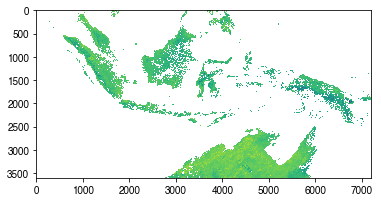

In [40]:
mp.imshow(lst_day_mosaic_ALL_DATA[0,:,:])

/export/home/blangenb/miniconda3/lib/python3.6/site-packages/matplotlib/image.py:405: UserWarning: Warning: converting a masked element to nan.
  dv = (np.float64(self.norm.vmax) -
/export/home/blangenb/miniconda3/lib/python3.6/site-packages/matplotlib/image.py:406: UserWarning: Warning: converting a masked element to nan.
  np.float64(self.norm.vmin))
/export/home/blangenb/miniconda3/lib/python3.6/site-packages/matplotlib/image.py:412: UserWarning: Warning: converting a masked element to nan.
  a_min = np.float64(newmin)
/export/home/blangenb/miniconda3/lib/python3.6/site-packages/matplotlib/image.py:417: UserWarning: Warning: converting a masked element to nan.
  a_max = np.float64(newmax)
/export/home/blangenb/miniconda3/lib/python3.6/site-packages/matplotlib/colors.py:916: UserWarning: Warning: converting a masked element to nan.
  dtype = np.min_scalar_type(value)
/export/home/blangenb/miniconda3/lib/python3.6/site-packages/numpy/ma/core.py:716: UserWarning: Warning: converting a 

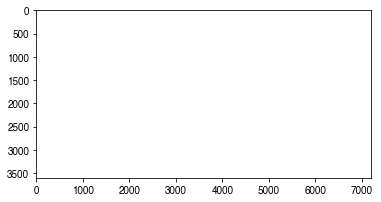

In [41]:
mp.imshow(lst_day_mosaic_ALL_DATA[1,:,:])

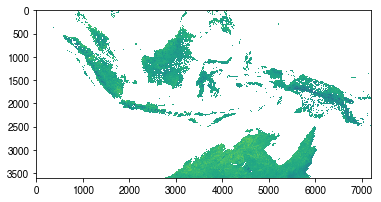

In [42]:
mp.imshow(lst_day_mosaic_ALL_DATA[2,:,:])